# Experiment A: Bound Adherence Under Nonstationary Conditions
*Question: does empirical average regret stay within the $\gamma$-regret bounds?*

### Experiment Design
Grid search over the streams (stationary, slow, abrupt, periodic), lambda levels, and two deletion ratio regimes.

Use a static comparator and calibrated learning rate schedule.
Set gamma per-theory at calibration and fix the total horizon (ie. $T=50000$).

### Preliminary Analysis

We first confirm whether the amount of drift assumed in the learner is the same as the drift realized in the stream. We do this by tracking the path length, $P_{T}$, and cumulative squared gradient (AdaGrad statistic), $S_{T}$.

This is to confirm that our theoretical assumptions are met. We have a rare opportunity here to not only worked with synthetic data, but directly configure it to align with out theoretical parameters, ie. $G$.

In [1]:
# --- Prerequisites (uncomment if needed) ---
# %pip install duckdb pandas matplotlib
# %pip install exp_engine  # if distributed as a package; else ensure it's on PYTHONPATH

import duckdb, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
from exp_engine.engine.duck import create_connection_and_views

plt.rcParams.update({'figure.figsize': (5,3), 'axes.grid': True})

BASE_OUT = "results_parquet"  # <--- change if your Parquet base_out lives elsewhere

conn = create_connection_and_views(BASE_OUT)
conn.execute("PRAGMA threads=8;")
conn.execute("PRAGMA enable_progress_bar=false;")

print("Connected. Views available:")
print(conn.execute("SHOW TABLES;").df())

Connected. Views available:
             name
0          events
1  events_summary
2           seeds
3   seeds_summary


In [2]:

seed_cols = set(conn.execute("DESCRIBE seeds").df()["column_name"])
print(seed_cols)

seed_cols = set(conn.execute("DESCRIBE events").df()["column_name"])
print(seed_cols)

{'gamma_pass_delete', 'drift_rate', 'target_c', 'total_events', 'gamma_bar', 'accountant', 'D_cap', 'delete_ratio', 'noise_std', 'm_theory_live', 'max_g_norm', 'target_D', 'gamma_insert_threshold', 'gamma_pass_insert', 'm_max', 'N_star_theory', 'gamma_error', 'gamma_split', 'algo', 'target_C_1', 'target_ST', 'log_privacy_spend', 'avg_regret_empirical', 'N_star_emp', 'm_emp', 'rho_spent_final', 'delta_b', 'w_scale', 'ST_final', 'odometer_mode', 'gamma_split_threshold', 'feature_scale', 'delta_total', 'lambda_est', 'gamma_delete_threshold', 'grid_id', 'ema_beta', 'fix_w_norm', 'ST_error', 'avg_clip_rate', 'sigma_step_theory', 'rho_total', 'C_hat_1', 'target_PT', 'eps_total', 'seed', 'dim', 'D_hat', 'G_hat', 'quantile', 'max_events', 'gamma_pass_overall', 'final_acc', 'avg_regret_final', 'enable_oracle', 'lambda_', 'N_star_live', 'eta_t', 'target_lambda', 'bootstrap_iters', 'strong_convexity', 'PT_final', 'rho_util', 'S_scalar', 'PT_error', 'target_G', 'path_style', 'blocked_reason', 'gam

In [3]:
command = """
SHOW TABLES;
"""
df = conn.execute(command).df()
print(df)

             name
0          events
1  events_summary
2           seeds
3   seeds_summary


In [4]:
command = f"""
SELECT DISTINCT grid_id
FROM events e
LIMIT 1000
;
"""
result = conn.execute(command).df()

# pick a random N grid IDs
N = 10
grid_ids = result["grid_id"].sample(N, random_state=42).tolist()
# convert to strings
grid_ids = [str(id) for id in grid_ids]

In [5]:
grid_ids

['gamma_0.2-split_0.6_q0.95_k1_zcdp_rho1.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT400_ST40000_G2.00_lam0.05_c0.1-C10_h23c18e6a',
 'gamma_0.2-split_0.6_q0.95_k20_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_hbcc76107',
 'gamma_0.2-split_0.6_q0.95_k5_zcdp_rho0.5_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h0a11297d',
 'gamma_0.3-split_0.7_q0.95_k20_zcdp_rho0.2_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT400_ST40000_G2.00_lam0.05_c0.1-C10_h693e19e7',
 'gamma_0.4-split_0.7_q0.95_k1_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h1318ac99',
 'gamma_0.3-split_0.7_q0.95_k5_zcdp_rho0.2_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT250_ST40000_G2.00_lam0.05_c0.1-C10_h267424c7',
 'gamma_0.2-split_0.6_q0.95_k1_zcdp_rho2.0_cmpdynamic_orcoff_prot_ang0.01_dr0.001_fs1_PT400_ST40000_G2.00_lam0.05_c0.1-C10_he0e3a050',
 'gamma_0.3-split_0.7_q0.95_k20_zcdp_rho0.2_cmpdynami

In [14]:
sample = []
for id in grid_ids:
    command = f"""
    SELECT grid_id
        , seed
        , regret
        , path_regret_increment
        , regret_increment
        , P_T
        , event_id
        , cum_regret
        , event
        , op
    FROM events e
    WHERE e.grid_id = '{id}'
    AND e.op != 'calibrate'
    ;
    """
    result = conn.execute(command).df()
    sample.append(result)

data = pd.concat(sample, ignore_index=True)

In [15]:
data.head()

,grid_id,seed,regret,path_regret_increment,regret_increment,P_T,event_id,cum_regret,event,op
0,gamma_0.4-split_0.7_q0.95_k5_zcdp_rho0.5_cmpdy...,0,-0.012624,0.0,-0.012624,0.0,1048,-0.012624,1050,insert
1,gamma_0.4-split_0.7_q0.95_k5_zcdp_rho0.5_cmpdy...,0,0.033312,0.0,0.033312,0.0,1049,0.020688,1051,insert
2,gamma_0.4-split_0.7_q0.95_k5_zcdp_rho0.5_cmpdy...,0,0.022830,0.0,0.022830,0.0,1050,0.043518,1052,insert
3,gamma_0.4-split_0.7_q0.95_k5_zcdp_rho0.5_cmpdy...,0,0.002672,0.0,0.002672,0.0,1051,0.046189,1053,insert
4,gamma_0.4-split_0.7_q0.95_k5_zcdp_rho0.5_cmpdy...,0,-0.051817,0.0,-0.051817,0.0,1052,-0.005628,1054,insert


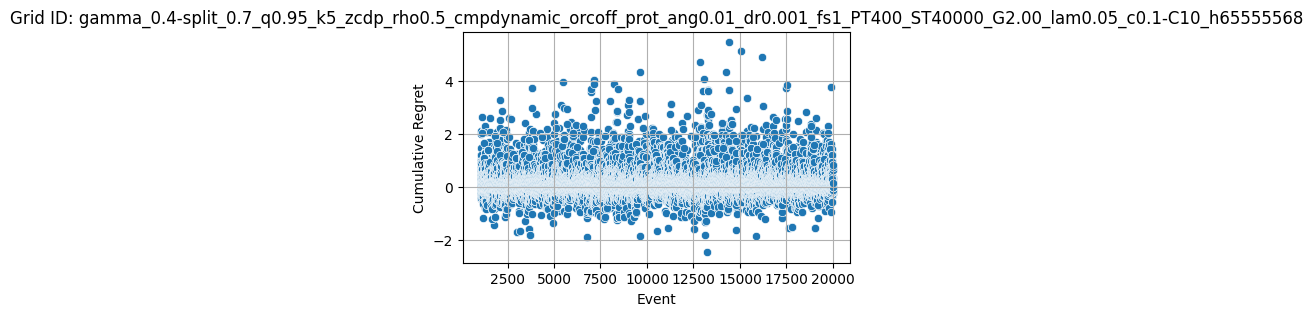

In [18]:
# plot event against regret for each grid ID
for grid_id in data["grid_id"].unique():
    subset = data[data["grid_id"] == grid_id]
    sns.scatterplot(data=subset, x="event", y="regret_increment")
    plt.title(f"Grid ID: {grid_id}")
    plt.xlabel("Event")
    plt.ylabel("Cumulative Regret")
    plt.show()

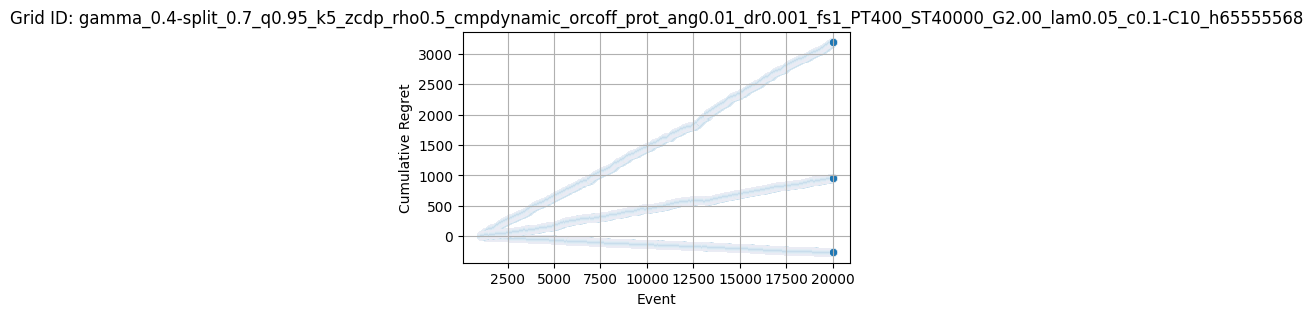

In [17]:
# plot event against regret for each grid ID
for grid_id in data["grid_id"].unique():
    subset = data[data["grid_id"] == grid_id]
    sns.scatterplot(data=subset, x="event", y="cum_regret")
    plt.title(f"Grid ID: {grid_id}")
    plt.xlabel("Event")
    plt.ylabel("Cumulative Regret")
    plt.show()

In [10]:
# pull grid IDs ending in h65555568
grid_ids = conn.execute("""
SELECT DISTINCT grid_id
FROM events
WHERE grid_id LIKE '%h65555568'
""").df()["grid_id"].tolist()

# pull corresponding events
events = conn.execute(f"""
SELECT *
FROM events
WHERE grid_id IN ({','.join(f"'{id}'" for id in grid_ids)})
""").df()

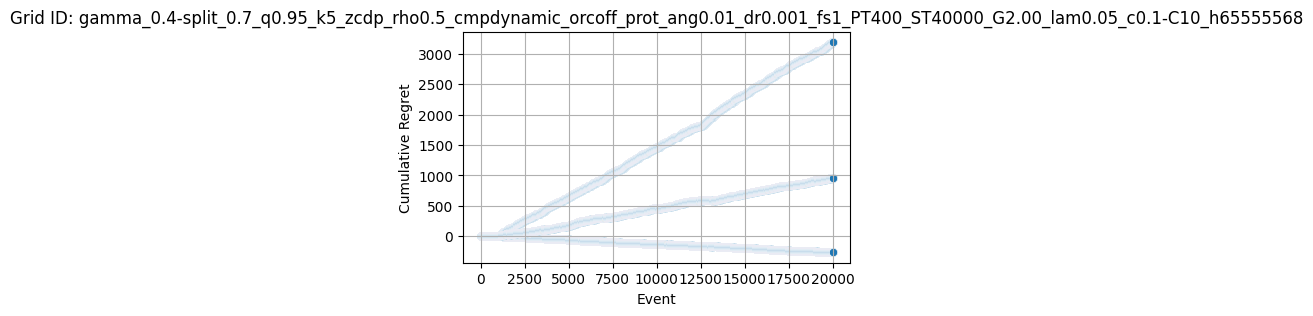

In [11]:
# plot cumulative regret
for grid_id in events["grid_id"].unique():
    subset = events[events["grid_id"] == grid_id]
    sns.scatterplot(data=subset, x="event", y="cum_regret")
    plt.title(f"Grid ID: {grid_id}")
    plt.xlabel("Event")
    plt.ylabel("Cumulative Regret")
    plt.show()

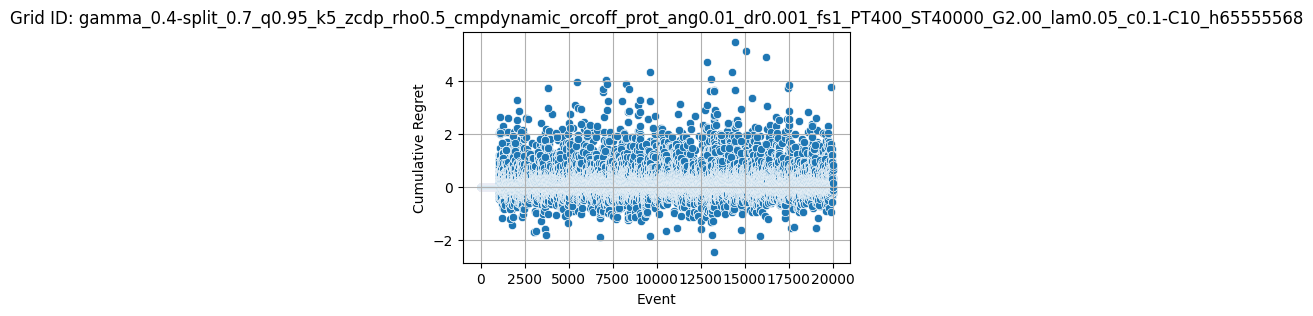

In [12]:
# plot cumulative regret
for grid_id in events["grid_id"].unique():
    subset = events[events["grid_id"] == grid_id]
    sns.scatterplot(data=subset, x="event", y="regret")
    plt.title(f"Grid ID: {grid_id}")
    plt.xlabel("Event")
    plt.ylabel("Cumulative Regret")
    plt.show()

In [13]:
# plot cumulative regret
for grid_id in events["grid_id"].unique():
    subset = events[events["grid_id"] == grid_id]
    sns.scatterplot(data=subset, x="event", y="incremental_regret")
    plt.title(f"Grid ID: {grid_id}")
    plt.xlabel("Event")
    plt.ylabel("Cumulative Regret")
    plt.show()


ValueError: Could not interpret value `incremental_regret` for `y`. An entry with this name does not appear in `data`.

In [ ]:
result = conn.execute("""
WITH e AS (
  SELECT grid_id, seed, op,
         -- pick the field you believe is “regret”; adjust if your column is regret_increment or margin, etc.
         CAST(regret AS DOUBLE) AS r
  FROM events
  WHERE grid_id = '<PUT_GRID_ID_HERE>'
)
SELECT
  op,
  COUNT(*)                      AS n,
  AVG(r)                        AS mean_r,
  MIN(r)                        AS min_r,
  MAX(r)                        AS max_r,
  AVG(CASE WHEN r < 0 THEN 1 ELSE 0 END) AS frac_neg
FROM e
GROUP BY 1;
""").df()

print(result)

Empty DataFrame
Columns: [op, n, mean_r, min_r, max_r, frac_neg]
Index: []


### Primary Analysis

For each of the experimental cells, evaluate the final $R_{T}/T$ to see whether the guarantee was met.
Multiple seeds per cell in order to make some kind of causal analysis on the results.

### Success Criteria
95% of the cells meet their guarantees then I would call that a success. Which cells experience more successes than others? Can I make a heatmap that shows the regret results per cell?